In [1]:
import keras
import json
import os, sys, h5py
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K 

import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import util

In [ ]:
def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [2]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = (dice_numerator) / (dice_denominator)
    

    return dice_coefficient

In [3]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
    
    ### END CODE HERE ###

    return dice_coefficient

In [4]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))


    return dice_loss

In [5]:
unet_model = util.unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [6]:
unet_model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 160, 160, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 160, 160, 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 160, 160, 55360       activation[0][0]                 
______________________________________________________________________________________________

In [7]:
base_dir = "BraTS-Data/processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)
    
#The batch size is a hyperparameter that defines the number of samples to work through before updating the internal 
#model parameters.
#Think of a batch as a for-loop iterating over one or more samples and making predictions. 
#At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. 
#From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.

# Get generators for training and validation sets
train_generator = util.VolumeDataGenerator(config["train"], base_dir + "train_standardize/", batch_size=1, dim=(160, 160, 16), verbose=0)
valid_generator = util.VolumeDataGenerator(config["valid"], base_dir + "valid_standardize/", batch_size=1, dim=(160, 160, 16), verbose=0)

In [8]:
#steps_per_epoch = 10

#Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.

#The number of epochs is a hyperparameter that defines the number of times that the learning algorithm will work through 
#the entire training dataset. You can think of a for-loop over the number of epochs where each loop proceeds over the 
#training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, 
#where one batch has the specified “batch size” number of samples.

n_epochs= 1

#lr = 0.001
#validation_steps = 10

unet_history = unet_model.fit(x=train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        verbose = 1,
        #use_multiprocessing=True,
        validation_data=valid_generator)
        #validation_steps=validation_steps)

11610/11610 [==============================] - 12934s 1s/step - loss: 0.3239 - dice_coefficient: 0.5826 - val_loss: 0.1431 - val_dice_coefficient: 0.7772


In [96]:
val_loss, val_dice = unet_model.evaluate(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

2910/2910 [==============================] - 600s 206ms/step - loss: 0.1367 - dice_coefficient: 0.8035
validation soft dice loss: 0.1367
validation dice coefficient: 0.8035


In [98]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [99]:
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

In [100]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity     0.0                 0.0          0.0062
Specificity  0.7711              0.4873             0.0


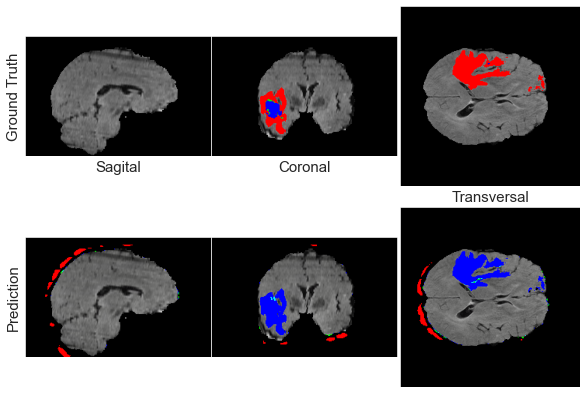

In [15]:
DATA_DIR = "Data/Valid"

image, label = load_case(DATA_DIR + "/BRATS_402.nii.gz", DATA_DIR + "_labels/BRATS_402.nii.gz")
pred = util.predict_and_viz(image, label, unet_model, .5, loc=(130, 130, 77))

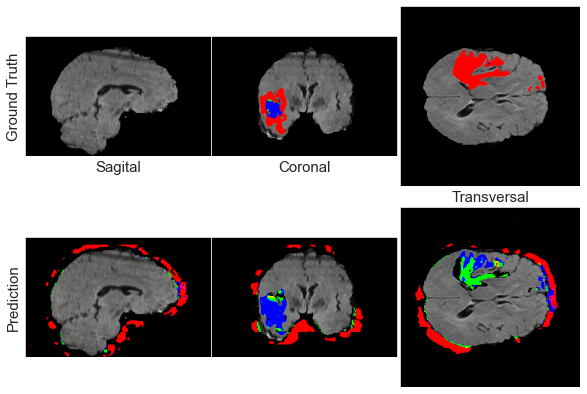

In [101]:
DATA_DIR = "Data/Valid"

image, label = load_case(DATA_DIR + "/BRATS_402.nii.gz", DATA_DIR + "_labels/BRATS_402.nii.gz")
pred = util.predict_and_viz(image, label, unet_model, .5, loc=(130, 130, 77))

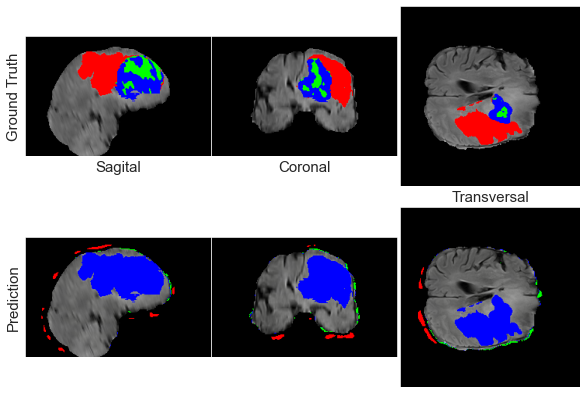

In [16]:
DATA_DIR = "Data/Valid"

image, label = load_case(DATA_DIR + "/BRATS_448.nii.gz", DATA_DIR + "_labels/BRATS_448.nii.gz")
pred = util.predict_and_viz(image, label, unet_model, .5, loc=(130, 130, 77))

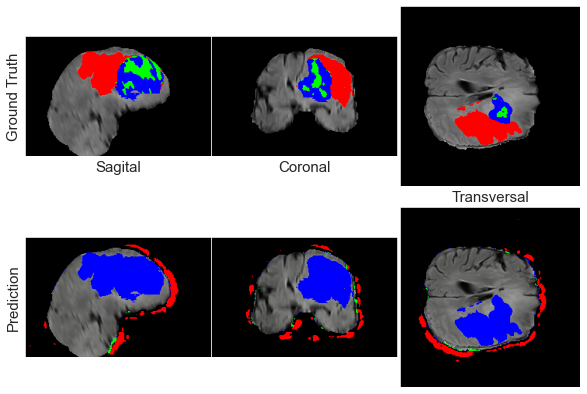

In [102]:
DATA_DIR = "Data/Valid"

image, label = load_case(DATA_DIR + "/BRATS_448.nii.gz", DATA_DIR + "_labels/BRATS_448.nii.gz")
pred = util.predict_and_viz(image, label, unet_model, .5, loc=(130, 130, 77))

### History

### Dotreniravanje

In [93]:
#counter of epochs = 1 + 3

#steps_per_epoch = 10

#Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.

#The number of epochs is a hyperparameter that defines the number of times that the learning algorithm will work through 
#the entire training dataset. You can think of a for-loop over the number of epochs where each loop proceeds over the 
#training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, 
#where one batch has the specified “batch size” number of samples.

n_epochs= 3

#lr = 0.001
#validation_steps = 10

unet_history = unet_model.fit(x=train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        verbose = 1,
        #use_multiprocessing=True,
        validation_data=valid_generator)
        #validation_steps=validation_steps)

Epoch 1/3
11610/11610 [==============================] - 12827s 1s/step - loss: 0.1387 - dice_coefficient: 0.7815 - val_loss: 0.1376 - val_dice_coefficient: 0.7855
Epoch 2/3
11610/11610 [==============================] - 12738s 1s/step - loss: 0.1180 - dice_coefficient: 0.8105 - val_loss: 0.1351 - val_dice_coefficient: 0.7965
Epoch 3/3
11610/11610 [==============================] - 12892s 1s/step - loss: 0.1022 - dice_coefficient: 0.8340 - val_loss: 0.1367 - val_dice_coefficient: 0.8035


### Save model

In [94]:
# serialize model to JSON
model_json = unet_model.to_json()
with open("unet_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
unet_model.save_weights("unet_model.h5")
print("Saved model to disk")

15198

Saved model to disk


In [ ]:
# load json and create model
json_file = open('unet_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("unet_model.h5")
print("Loaded model from disk")

### Filter visualization

In [103]:
layer_dict = dict([(layer.name, layer) for layer in unet_model.layers])

layer_name = 'conv3d'
filter_index = 0 # Which filter in this block would you like to visualise?

# Grab the filters and biases for that layer
filters, biases = layer_dict[layer_name].get_weights()

# Normalize filter values to a range of 0 to 1 so we can visualize them
f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters - f_min) / (f_max - f_min)

In [104]:
filters.shape

(3, 3, 3, 4, 32)

In [105]:
f = filters[:, :, :, 1]
f.shape

(3, 3, 3, 32)

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

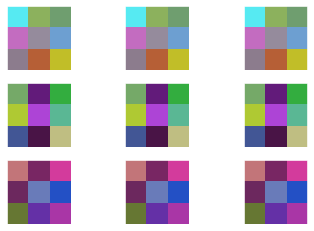

In [106]:
# Plot first few filters
n_filters, index = 3, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    
    # Plot each channel separately
    for j in range(3):

        ax = plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, :, 0], cmap='viridis')
        index += 1
        
plt.show()

In [107]:
layer_dict = dict([(layer.name, layer) for layer in unet_model.layers])

layer_name = 'conv3d_10'
filter_index = 0 # Which filter in this block would you like to visualise?

# Grab the filters and biases for that layer
filters, biases = layer_dict[layer_name].get_weights()

# Normalize filter values to a range of 0 to 1 so we can visualize them
f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters - f_min) / (f_max - f_min)

In [108]:
filters.shape

(3, 3, 3, 384, 128)

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

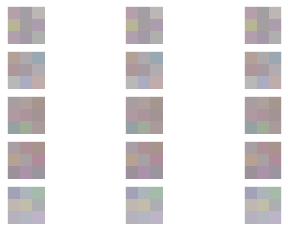

In [109]:
# Plot first few filters
n_filters, index = 5, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    
    # Plot each channel separately
    for j in range(3):

        ax = plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, :, 0], cmap='viridis')
        index += 1
        
plt.show()